### **Cell 1: Imports 📦**

This cell loads all the tools we'll need for the entire project. Each import has a specific role, from handling the network data to running the optimization and analyzing the results.

* `igraph as ig`: This is the core library for creating, manipulating, and analyzing our network data. We use the alias `ig` for convenience.
* `leidenalg as la`: This library provides the powerful **Leiden algorithm** for community detection, which is the main algorithm we are tuning. We'll use the alias `la`.
* `numpy as np`: A fundamental package for numerical computation in Python. While `igraph` handles many calculations, `numpy` is often useful for data manipulation.
* `pandas as pd`: We'll use this for organizing our optimization results into a structured and easy-to-analyze **DataFrame**.
* `sklearn.metrics.normalized_mutual_info_score`: This is the specific function we'll use to measure how well our detected communities match the **ground truth**. Normalized Mutual Information (NMI) is a standard metric for this task.
* `from hyperopt import ...`: This imports the necessary components from the **hyperopt** library.
    * `fmin`: The main function that runs the optimization process.
    * `tpe`: The Tree-of-Parzen-Estimators algorithm, a form of Bayesian optimization that will intelligently guide our search.
    * `hp`: This module helps us define the **search space** for our hyperparameters (e.g., specifying ranges and choices).
    * `Trials`: An object to store the history of our optimization search (every set of parameters tried and the resulting loss).
    * `STATUS_OK`: A constant we return from our objective function to signal that a trial completed successfully.
* `matplotlib.pyplot as plt`: The standard library for creating plots and visualizations in Python, which we'll use for our analysis.

In [ ]:
import igraph as ig
import leidenalg as la
import numpy as np
import pandas as pd
from sklearn.metrics import normalized_mutual_info_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import matplotlib.pyplot as plt



### **Cell 2: Load Benchmark Data 🕸️**

For this project, we'll use a classic benchmark dataset in network science: **Zachary's Karate Club**. This graph represents the social network of a university karate club that famously split into two factions. Because the real-world outcome of this split is known, it provides a perfect "ground truth" to test how well our community detection algorithms perform.

* `ig.Graph.Famous("Zachary")`: We call this special constructor from `igraph` to load the well-known network directly into memory. There's no need to load it from a file.
* `g = ...`: We assign the resulting graph object to the variable `g`. This will be our primary network object for the rest of the project.
* `ig.summary(g)`: This command provides a concise overview of the graph. The output `IGRAPH UNW- 34 78 -- ...` tells us:
    * **U**: It's an **U**ndirected graph.
    * **N**: It's a **N**amed graph (vertices have a `name` attribute).
    * **W**: It's a **W**eighted graph (edges have a `weight` attribute).
    * **34**: It has 34 vertices (club members).
    * **78**: It has 78 edges (friendships).
* `.attributes()`: We inspect the vertex and edge attributes to see what data came with the graph. Notice the `Faction` vertex attribute; this indicates which of the two factions each member joined after the split. We will use this information in the next step to define our ground truth.

In [ ]:
# Load the Zachary's Karate Club graph using the .Famous() constructor
g = ig.Graph.Famous("Zachary")

# Print a summary of the graph to verify it was loaded correctly
print("Graph summary:")
ig.summary(g)

# The .Famous() constructor often includes useful attributes. Let's inspect them.
print("\nVertex attributes:", g.vs.attributes())
print("Edge attributes:", g.es.attributes())

### **Cell 3: Define Ground Truth 🗺️**

Now that we have our graph, we need to formally define the "correct answer" we're trying to find. This is the **ground truth partition**. For the Karate Club, this is the well-documented, real-world split of the club into two factions, one around the instructor ("Mr. Hi") and the other around the club president ("John A.").

By defining this upfront, we establish a clear benchmark to measure the success of our algorithm. Our goal is to find the set of parameters that allows the Leiden algorithm to discover a community structure that most closely matches this ground truth.

* `ground_truth_membership`: We create a simple Python list that assigns each of the 34 vertices (club members) to one of two communities, labeled `0` and `1`. This specific list is the widely accepted correct partition for this benchmark network.
* `ig.VertexClustering(g, membership=...)`: We take our raw membership list and use it to create a `VertexClustering` object. This is the standard data structure that both `igraph` and `leidenalg` use for community partitions. Using this object ensures that our ground truth is in the exact same format as the results from our algorithm, which is essential for a direct comparison.
* `ground_truth_partition = ...`: We store this formal partition in a variable. It will be used in our objective function to calculate the NMI score.

In [ ]:
# The canonical ground-truth partition of the 34 members of the karate club.
# Community '0' is the faction of the instructor, Mr. Hi.
# Community '1' is the faction of the club president, John A.
ground_truth_membership = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# To make this compatible with igraph's functions, we convert the list
# into a VertexClustering object. This is the standard data structure
# for representing partitions and makes it easy to compare with the
# output of the community detection algorithms.
ground_truth_partition = ig.VertexClustering(g, membership=ground_truth_membership)

# Print the partition object to confirm it was created correctly.
# It shows the number of communities and the members in each.
print("Ground truth partition defined successfully:")
print(ground_truth_partition)

### **Cell 4 : Define the Hyperparameter Search Space 🔬**

This is where we lay out all the possible choices and parameter ranges that `hyperopt` will explore. Our goal is to create a structure that allows the optimizer to not only tune parameters *within* a model but also to choose *between* completely different models (quality functions).

* **`hp.choice('quality_function', [...])`**: This is the top-levelinstruction for `hyperopt`. In each evaluation (trial), it will select one of the items from the list we provided. Each item is a dictionary representing a model configuration to test.

* **Model Configuration Dictionaries**:
    * Each dictionary has a `'name'` key (e.g., `'Modularity'`). We will use this in our next step (the objective function) to know which `leidenalg` algorithm to run.
    * Each dictionary contains the specific hyperparameters for that model.

* **Defining Hyperparameters**:
    * **`hp.uniform('res_rb', 0.0, 2.0)`**: For the `RBConfigurationVertexPartition`, we are telling `hyperopt` to search for the best `resolution_parameter` within the continuous range of 0.0 to 2.0.
    * **`hp.randint('seed_modularity', 0, 10000)`**: Since the Leiden algorithm is stochastic, we treat the `seed` as a hyperparameter. `hp.randint` tells `hyperopt` to pick an integer within the given range.

* **Unique Labels and Dummy Parameters**: This is a crucial point from the project's "lessons learned."
    * Every single hyperparameter has a **unique label** (e.g., `'seed_modularity'`, `'res_rb'`). This is essential because it allows us to unambiguously identify which model and parameters were used when we analyze the results later.
    * For models like `Surprise` and `Significance` that have no tunable parameters, we include a unique **"dummy" parameter**, which serves only as an identifier.

* **Verification**: The final `print(search_space)` command outputs `hyperopt`'s internal graph representation of the search space, often called a `pyll` graph. This complex-looking output confirms that `hyperopt` has correctly parsed our definitions into a structure it can sample from.

### Choosing a Quality Function: Summary

The quality function you choose fundamentally defines what your algorithm considers a "good" community.

| Quality Function | Core Idea | Best For | Key Limitation |
| :--- | :--- | :--- | :--- |
| **Modularity** | More internal edges than expected by chance. | Finding a few large, well-separated communities. | **Resolution Limit**: Fails to detect small communities. |
| **Surprise** | The observed number of internal edges is highly improbable. | Finding communities of various sizes, especially small ones. | Can be overly "discriminative" and split large communities. |
| **Significance**| Is this community a statistically real feature of the network?| Avoiding false positives and being confident in each community. | Can be computationally intensive and conceptually complex.|

---

### A Practical Rule of Thumb

The best approach is often to use multiple methods and compare the results. If different quality functions agree on a community structure, you can be much more confident in its validity.

1.  **Start with Modularity**: It's the classic for a reason. Run a modularity-based algorithm to get a first impression of your network's structure.

2.  **If you suspect missed communities, try Surprise**: If the communities from modularity seem too large or you have prior knowledge suggesting smaller groups exist, use Surprise to see if it can uncover these finer-grained structures.

3.  **Use Significance for validation**: If you need to be highly confident in the detected communities and want to avoid spurious results (especially in fields like biology or finance), use a significance-based method to validate your findings.

In [17]:
# Define the search space for hyperopt.
# This structure allows hyperopt to choose between different quality functions
# and tune their respective hyperparameters.
search_space = hp.choice('quality_function', [
    {
        'name': 'Modularity',
        'seed': hp.randint('seed_modularity', 0, 10000)
    },
    {
        'name': 'RBConfiguration',
        'resolution_parameter': hp.uniform('res_rb', 0.0, 2.0),
        'seed': hp.randint('seed_rb', 0, 10000)
    },
    {
        'name': 'Surprise',
        # This dummy parameter is for unique identification in the results,
        # as SurpriseVertexPartition itself has no tunable parameters.
        'dummy_surprise': hp.uniform('dummy_surprise', 1.0, 1.1),
        'seed': hp.randint('seed_surprise', 0, 10000)
    },
    {
        'name': 'Significance',
        # This dummy parameter is also for unique identification.
        'dummy_significance': hp.uniform('dummy_significance', 1.0, 1.1),
        'seed': hp.randint('seed_sig', 0, 10000)
    }
])

# Print the search space object to verify its structure.
print("Hyperopt search space defined successfully. The object structure is:")
print(search_space)

Hyperopt search space defined successfully. The object structure is:
0 switch
1   hyperopt_param
2     Literal{quality_function}
3     randint
4       Literal{4}
5   dict
6    name =
7     Literal{Modularity}
8    seed =
9     hyperopt_param
10       Literal{seed_modularity}
11       randint
12         Literal{0}
13         Literal{10000}
14   dict
15    name =
16     Literal{RBConfiguration}
17    resolution_parameter =
18     float
19       hyperopt_param
20         Literal{res_rb}
21         uniform
22           Literal{0.0}
23           Literal{2.0}
24    seed =
25     hyperopt_param
26       Literal{seed_rb}
27       randint
28         Literal{0}
29         Literal{10000}
30   dict
31    dummy_surprise =
32     float
33       hyperopt_param
34         Literal{dummy_surprise}
35         uniform
36           Literal{1.0}
37           Literal{1.1}
38    name =
39     Literal{Surprise}
40    seed =
41     hyperopt_param
42       Literal{seed_surprise}
43       randint
44         Liter

In [16]:
PARTITION_TYPE_MAP = {
    'RBConfiguration': la.RBConfigurationVertexPartition,
    'Surprise': la.SurpriseVertexPartition,
    'Significance': la.SignificanceVertexPartition,
}

### **Cell 5: The Objective Function 🎯 — A Detailed Breakdown**

This function is the core of our experiment. `hyperopt` will call it repeatedly with different parameter combinations from our `search_space` to find the one that performs best.

#### **Overall Purpose**

The function's job is to provide a single, consistent way for `hyperopt` to evaluate any set of parameters. It takes the parameters, runs the correct `leidenalg` algorithm, compares the result to our ground truth, and returns a single "loss" score for `hyperopt` to minimize.

#### **Function Definition and Parameter Unpacking**

```python
def objective_function(params):
    model_name = params['name']
    seed = params['seed']
```

The function accepts a single argument, `params`, which is a dictionary containing one complete sample from our `search_space`. We immediately unpack the `model_name` and `seed` as they are common to all models.

#### **The `if model_name == 'Modularity':` Block (Special Case)**

```python
if model_name == 'Modularity':
    partition = la.ModularityVertexPartition(g)
    optimiser = la.Optimiser()
    optimiser.set_rng_seed(seed)
    optimiser.optimise_partition(partition, n_iterations=-1)
```

This block is a direct solution to a known API difference noted in your project summary.

* **`la.ModularityVertexPartition(g)`**: We first create a `ModularityVertexPartition` instance. The documentation shows its constructor does not accept a `seed`.
* **`la.Optimiser()`**: To control the process, we create a separate `Optimiser` object.
* **`optimiser.set_rng_seed(seed)`**: The `Optimiser` has a specific method to set the random seed, ensuring reproducibility for this run.
* **`optimiser.optimise_partition(...)`**: This method runs the actual Leiden algorithm on our `partition` object. Setting `n_iterations=-1` instructs the algorithm to run until it converges, which is best practice for a thorough evaluation.

#### **The `else:` Block (General Case)**

```python
else:
    partition_type = PARTITION_TYPE_MAP[model_name]
    kwargs = {'seed': seed}
    if 'resolution_parameter' in params:
        kwargs['resolution_parameter'] = params['resolution_parameter']
    partition = la.find_partition(g, partition_type, n_iterations=-1, **kwargs)
```

This block handles all other, more straightforward, models.

* **`PARTITION_TYPE_MAP`**: We use our lookup table to get the correct `leidenalg` class object (e.g., `la.RBConfigurationVertexPartition`).
* **`kwargs`**: We build a dictionary of arguments to pass to the main function. This robustly handles optional parameters like `resolution_parameter`.
* **`la.find_partition(...)`**: This is the high-level function in `leidenalg` that creates and optimizes a partition in one step. It conveniently accepts `seed` and `resolution_parameter` as arguments. Again, we use `n_iterations=-1` for convergence.

#### **NMI and Loss Calculation**

```python
nmi = normalized_mutual_info_score(
    ground_truth_partition.membership,
    partition.membership,
    average_method='arithmetic'
)
loss = 1 - nmi
```

* **`nmi = ...`**: After running the algorithm, we have a `partition` object. We calculate its NMI score by comparing its `.membership` list to our `ground_truth_partition`.
* **`loss = 1 - NMI`**: This is a crucial transformation. `hyperopt`'s `fmin` function is a **minimizer**. Since we want to **maximize** NMI, we define `loss = 1 - NMI`. Minimizing this value is equivalent to maximizing NMI.

#### **The Return Statement**

```python
return {'loss': loss, 'status': STATUS_OK}
```

The function must return a dictionary with these two specific keys, as required by the `hyperopt` API. `'loss'` is the value `fmin` will use to judge this trial, and `'status': STATUS_OK` signals that the trial completed successfully.

In [19]:
# This dictionary maps the model names from our search space
# to the actual leidenalg partition class objects.
PARTITION_TYPE_MAP = {
    'RBConfiguration': la.RBConfigurationVertexPartition,
    'Surprise': la.SurpriseVertexPartition,
    'Significance': la.SignificanceVertexPartition,
}

def objective_function(params):
    """
    The objective function for hyperopt to minimize.

    It takes a dictionary of parameters, runs the corresponding
    leidenalg community detection, and returns the loss (1 - NMI).
    """
    # Extract the name of the quality function and the random seed.
    model_name = params['name']
    seed = params['seed']

    # The ModularityVertexPartition has a different API and must be handled separately.
    if model_name == 'Modularity':
        # For Modularity, we use the lower-level Optimiser API to pass the seed.
        partition = la.ModularityVertexPartition(g)
        optimiser = la.Optimiser()
        optimiser.set_rng_seed(seed)
        # n_iterations=-1 runs the algorithm until it converges to a stable partition.
        optimiser.optimise_partition(partition, n_iterations=-1)
    else:
        # For all other models, we can use the simpler find_partition API.
        partition_type = PARTITION_TYPE_MAP[model_name]

        # Build a dictionary of keyword arguments for the find_partition function.
        kwargs = {'seed': seed}
        if 'resolution_parameter' in params:
            kwargs['resolution_parameter'] = params['resolution_parameter']

        partition = la.find_partition(g, partition_type, n_iterations=-1, **kwargs)

    # Calculate the Normalized Mutual Information (NMI) against the ground truth.
    nmi = normalized_mutual_info_score(
        ground_truth_partition.membership,
        partition.membership,
        average_method='arithmetic'
    )

    # Hyperopt aims to MINIMIZE the loss. Since a HIGHER NMI is better,
    # we return (1 - NMI) as the loss value.
    loss = 1 - nmi

    # The function must return a dictionary with a 'loss' and a 'status' key.
    return {'loss': loss, 'status': STATUS_OK}


# --- Verification Step ---
# It's good practice to test the objective function with sample parameters
# before starting the full optimization run.
print("--- Testing the objective function ---")
print("Testing the general case (RBConfiguration)...")
sample_params_general = {
    'name': 'RBConfiguration',
    'resolution_parameter': 1.0,
    'seed': 42
}
test_result_general = objective_function(sample_params_general)
print(f"Test run successful. Loss: {test_result_general['loss']:.4f}")

print("\nTesting the special case (Modularity)...")
sample_params_modularity = {
    'name': 'Modularity',
    'seed': 42
}
test_result_modularity = objective_function(sample_params_modularity)
print(f"Test run successful. Loss: {test_result_modularity['loss']:.4f}")
print("------------------------------------")

# --- Deeper Verification Step ---
print("--- Verifying with different parameters ---")
print("Testing RBConfiguration with resolution = 0.5...")
sample_params_rb_varied = {
    'name': 'RBConfiguration',
    'resolution_parameter': 0.5, # Changed from 1.0
    'seed': 42
}
test_result_rb_varied = objective_function(sample_params_rb_varied)
print(f"Test run successful. Loss: {test_result_rb_varied['loss']:.4f}")

print("\nTesting Modularity (same as before)...")
sample_params_modularity = {
    'name': 'Modularity',
    'seed': 42
}
test_result_modularity = objective_function(sample_params_modularity)
print(f"Test run successful. Loss: {test_result_modularity['loss']:.4f}")
print("---------------------------------------")

--- Testing the objective function ---
Testing the general case (RBConfiguration)...
Test run successful. Loss: 0.3127

Testing the special case (Modularity)...
Test run successful. Loss: 0.3127
------------------------------------
--- Verifying with different parameters ---
Testing RBConfiguration with resolution = 0.5...
Test run successful. Loss: 0.1628

Testing Modularity (same as before)...
Test run successful. Loss: 0.3127
---------------------------------------


### **Cell 6: Run the Bayesian Optimization ✨**

This is the step where we put all our setup work into action and run the experiment. We hand over our `objective_function` and `search_space` to `hyperopt`'s main optimization engine, `fmin`.

* **`trials = Trials()`**: We create an empty `Trials` object. This acts as a logbook that `hyperopt` will use to meticulously record the details of every experiment it runs, including the parameters tested and the resulting loss.

* **`fmin(...)`**: This is the core optimization function from `hyperopt`. We provide it with everything it needs:
    * `fn=objective_function`: The function whose output (`loss`) we want to minimize.
    * `space=search_space`: The hyperparameter landscape we defined for it to explore.
    * `algo=tpe.suggest`: We specify the search algorithm. TPE (**Tree-of-Parzen-Estimators**) is a smart **Bayesian optimization** method that learns from the results of past trials to choose more promising parameters for future trials.
    * `max_evals=MAX_EVALS`: We set our computational budget. The optimizer will run the `objective_function` 200 times.
    * `trials=trials`: We pass our "logbook" object to `fmin` so it can store the complete history of the search.

When this cell runs, `hyperopt` displays a progress bar as it works through the 200 evaluations. At the end, the `best_params` variable holds the dictionary of the best-performing parameters it found—the set that resulted in the lowest loss (and therefore the highest NMI).

In [20]:
# Create a Trials object to store the history of the optimization process.
# This object will record the parameters, loss, and other info for each evaluation.
trials = Trials()

# Set the maximum number of evaluations (trials) for the optimization.
# For a real-world problem, you might increase this to 500 or more.
MAX_EVALS = 200

print(f"--- Starting Bayesian Optimization (TPE) for {MAX_EVALS} evaluations ---")

# Run the hyperparameter optimization using fmin.
# The fmin function will iteratively sample from the search_space,
# evaluate the objective_function, and update its belief about the best
# parameters.
best_params = fmin(
    fn=objective_function,
    space=search_space,
    algo=tpe.suggest,
    max_evals=MAX_EVALS,
    trials=trials
)

print("\n--- Optimization Complete ---")
print("Best parameters found by hyperopt:")
print(best_params)

--- Starting Bayesian Optimization (TPE) for 200 evaluations ---
  8%|███▌                                           | 15/200 [00:00<00:02, 71.62trial/s, best loss: 0.3005118390185184]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 26%|████████████▏                                 | 53/200 [00:01<00:04, 30.49trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 32%|██████████████▉                               | 65/200 [00:01<00:04, 28.05trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 45%|████████████████████▋                         | 90/200 [00:02<00:03, 32.15trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 47%|█████████████████████▌                        | 94/200 [00:02<00:03, 33.11trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 52%|███████████████████████▏                     | 103/200 [00:03<00:02, 32.76trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 54%|████████████████████████                     | 107/200 [00:03<00:03, 29.16trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 57%|█████████████████████████▊                   | 115/200 [00:03<00:02, 31.96trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 62%|███████████████████████████▋                 | 123/200 [00:03<00:02, 28.41trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 68%|██████████████████████████████▌              | 136/200 [00:04<00:02, 31.17trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



 98%|████████████████████████████████████████████▎| 197/200 [00:07<00:00, 26.75trial/s, best loss: 0.16283053712221907]

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)



100%|█████████████████████████████████████████████| 200/200 [00:07<00:00, 27.39trial/s, best loss: 0.16283053712221907]

--- Optimization Complete ---
Best parameters found by hyperopt:
{'quality_function': 1, 'res_rb': 0.40052927322515447, 'seed_rb': 3378}


### **Cell 7: Processing and Analyzing the Results 📊**

This cell's primary goal is to convert the raw, optimized log data from the `hyperopt` `trials` object into a structured, comprehensive `pandas` DataFrame. This DataFrame will contain not just the loss from each trial, but all the performance metrics we care about, making our final analysis much easier.

---
#### **The `get_trial_results` Helper Function**

We start by defining a helper function that can process a *single* set of hyperparameters and return all of our desired metrics. This isolates the logic for re-running one experiment.

```python
def get_trial_results(params):
    # ... function body ...
```

* **Parameter Unpacking**: The function takes a `params` dictionary and immediately unpacks the `model_name` and `seed`.
* **Conditional Logic**:
    * It uses an `if model_name == 'Modularity':` block to handle the special API requirements of the Modularity quality function, using the `leidenalg.Optimiser` class to correctly apply the seed.
    * The `else:` block handles all other quality functions using the standard, high-level `leidenalg.find_partition` function, dynamically passing arguments like `resolution_parameter` when they are present.
* **Robust Metric Calculation**:
    * After a `partition` is found, the function explicitly calculates `nmi`, `modularity`, and the `num_communities`.
    * Crucially, it calculates `modularity` and `conductance` using the main graph object (`g.modularity(...)` and `g.conductance(...)`). This is the most robust method as it works for any partition, regardless of how it was generated.
    * The `conductance` calculation is wrapped in a `try...except` block. This makes our script resilient to errors that can occur if a partition is generated for which conductance is mathematically undefined (e.g., a community is disconnected from the rest of the graph). If an error occurs, we assign a default "bad" score of `1.0`.
* **Return Dictionary**: The function assembles and returns a complete dictionary containing the original input parameters plus all the calculated performance metrics.

---
#### **The Main Processing Loop**

This is where we iterate through the `hyperopt` log and use our helper function.

```python
results_list = []
for trial in trials.trials:
    vals = {k: v[0] for k, v in trial['misc']['vals'].items() if v}
    params = space_eval(search_space, vals)
    trial_results = get_trial_results(params)
    results_list.append(trial_results)
```

* **`for trial in trials.trials:`**: We loop through the `.trials` attribute of our `trials` object. Each `trial` in this list is a dictionary containing the complete record of a single experiment.
* **`vals = {k: v[0] ... if v}`**: This line safely unpacks the parameter values for the current trial. It handles **conditional parameters** correctly. If a parameter was not used in a trial (e.g., `resolution_parameter` during a `Modularity` run), its value is an empty list `[]`. The `if v` check ensures we only process parameters that were actually active, thus avoiding the `IndexError`.
* **`params = space_eval(...)`**: This is a key `hyperopt` utility. It takes our defined `search_space` and the packed `vals` and correctly reconstructs the original, human-readable `params` dictionary that was used for the trial.
* **`results_list.append(...)`**: We call our helper function with the reconstructed `params` and append the resulting detailed dictionary to our `results_list`.

---
#### **Creating and Displaying the DataFrame**

Finally, we convert the collected data into a usable format.

```python
results_df = pd.DataFrame(results_list)
# ... cleanup and display ...
```

* **`results_df = pd.DataFrame(results_list)`**: We pass our list of dictionaries directly to the `pandas` DataFrame constructor. This is the standard way to create a DataFrame, where each dictionary becomes a row.
* **Cleanup**: We do some minor cleanup to move the model name into its own dedicated column for easier filtering later on.
* **`display(...)` and `.info()`**: We immediately sort the DataFrame by `nmi` to see our top 5 best-performing trials at a glance. The `.info()` call gives us a summary of the DataFrame's columns and data types, confirming that our data processing was successful.

In [28]:
from hyperopt import space_eval

def calculate_conductance(graph, partition):
    """
    Calculates the conductance of a partition.
    The conductance of a partition is the maximum conductance of any of its communities.
    Lower is better.
    """
    if graph.ecount() == 0:
        return 0.0
    if len(partition) <= 1:
        return 0.0

    conductances = []
    total_volume = 2 * graph.ecount()

    for community in partition:
        # Get the subgraph for the community
        subgraph = graph.subgraph(community)
        
        # Calculate the number of edges crossing the boundary
        cut_size = 0
        for vertex in community:
            for neighbor in graph.neighbors(vertex):
                if neighbor not in community:
                    cut_size += 1

        # Calculate the volume of the community
        community_volume = sum(graph.degree(community))

        # Denominator of the conductance formula
        denominator = min(community_volume, total_volume - community_volume)

        if denominator == 0:
            conductances.append(0.0)
        else:
            conductances.append(cut_size / denominator)
    
    # The conductance of the partition is the maximum value
    return max(conductances)


def get_trial_results(params):
    """
    A helper function to re-run the logic for a given set of parameters
    and return a dictionary with all relevant metrics.
    """
    model_name = params['name']
    seed = params['seed']

    if model_name == 'Modularity':
        partition = la.ModularityVertexPartition(g)
        optimiser = la.Optimiser()
        optimiser.set_rng_seed(seed)
        optimiser.optimise_partition(partition, n_iterations=-1)
    else:
        partition_type = PARTITION_TYPE_MAP[model_name]
        kwargs = {'seed': seed}
        if 'resolution_parameter' in params:
            kwargs['resolution_parameter'] = params['resolution_parameter']
        partition = la.find_partition(g, partition_type, n_iterations=-1, **kwargs)

    nmi = normalized_mutual_info_score(
        ground_truth_partition.membership,
        partition.membership,
        average_method='arithmetic'
    )
    modularity = g.modularity(partition.membership)
    num_communities = len(partition)
    
    # Use our new, correct function to calculate conductance
    conductance = calculate_conductance(g, partition)

    results = params.copy()
    results.update({
        'nmi': nmi,
        'modularity': modularity,
        'conductance': conductance,
        'num_communities': num_communities,
        'loss': 1 - nmi
    })
    return results

# --- Main Processing Logic ---
results_list = []
for trial in trials.trials:
    vals = {k: v[0] for k, v in trial['misc']['vals'].items() if v}
    params = space_eval(search_space, vals)
    trial_results = get_trial_results(params)
    results_list.append(trial_results)

results_df = pd.DataFrame(results_list)
results_df['model_name'] = results_df['name']
results_df = results_df.drop(columns=['name'])

print("--- Top 5 Trials by NMI Score (with correct conductance) ---")
display(results_df.sort_values('nmi', ascending=False).head())
print("\n--- DataFrame Info ---")
results_df.info()

C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)
C:\Users\basde\A

--- Top 5 Trials by NMI Score (with correct conductance) ---


C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:50: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(labels_pred)


,dummy_surprise,seed,nmi,modularity,conductance,num_communities,loss,resolution_parameter,dummy_significance,model_name
199,NaN,6946,0.837169,0.371795,0.128205,2,0.162831,0.494791,NaN,RBConfiguration
178,NaN,9229,0.837169,0.371795,0.128205,2,0.162831,0.418159,NaN,RBConfiguration
79,NaN,9553,0.837169,0.371795,0.128205,2,0.162831,0.294879,NaN,RBConfiguration
154,NaN,7706,0.837169,0.371795,0.128205,2,0.162831,0.603803,NaN,RBConfiguration
75,NaN,9421,0.837169,0.371795,0.128205,2,0.162831,0.403061,NaN,RBConfiguration



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   dummy_surprise        26 non-null     float64
 1   seed                  200 non-null    int64  
 2   nmi                   200 non-null    float64
 3   modularity            200 non-null    float64
 4   conductance           200 non-null    float64
 5   num_communities       200 non-null    int64  
 6   loss                  200 non-null    float64
 7   resolution_parameter  123 non-null    float64
 8   dummy_significance    26 non-null     float64
 9   model_name            200 non-null    object 
dtypes: float64(7), int64(2), object(1)
memory usage: 15.8+ KB


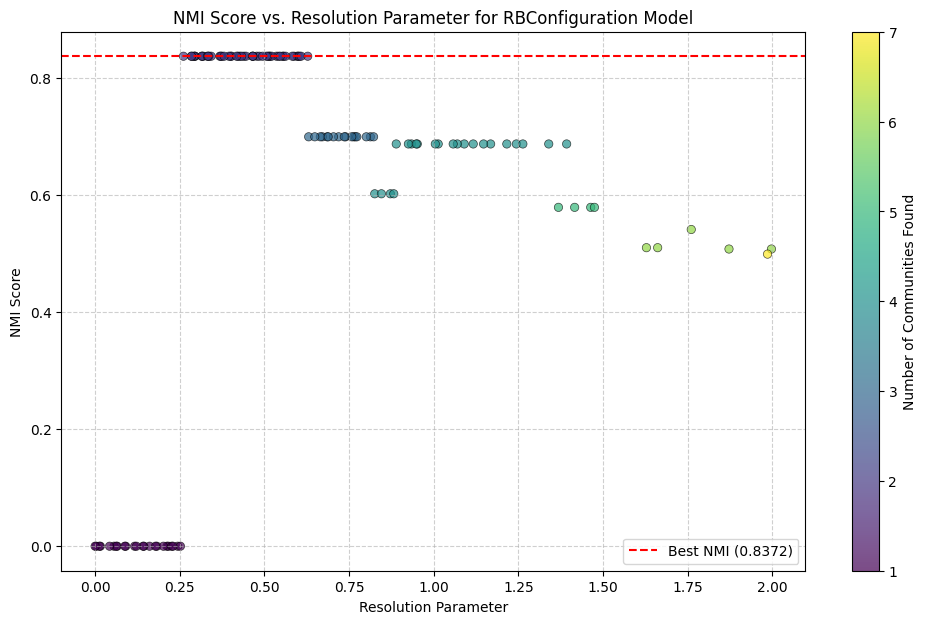

In [29]:
# Filter the DataFrame to only include results from the RBConfiguration model
rb_results = results_df[results_df['model_name'] == 'RBConfiguration'].copy()

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot the results, coloring points by the number of communities found
sc = ax.scatter(
    rb_results['resolution_parameter'],
    rb_results['nmi'],
    c=rb_results['num_communities'],
    cmap='viridis',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# Add a colorbar and set its label
cbar = plt.colorbar(sc)
cbar.set_label('Number of Communities Found')

# Add labels and title for clarity
ax.set_xlabel('Resolution Parameter')
ax.set_ylabel('NMI Score')
ax.set_title('NMI Score vs. Resolution Parameter for RBConfiguration Model')
ax.grid(True, linestyle='--', alpha=0.6)

# Highlight the best NMI score found
best_nmi = rb_results['nmi'].max()
ax.axhline(y=best_nmi, color='r', linestyle='--', label=f'Best NMI ({best_nmi:.4f})')

ax.legend()
plt.show()

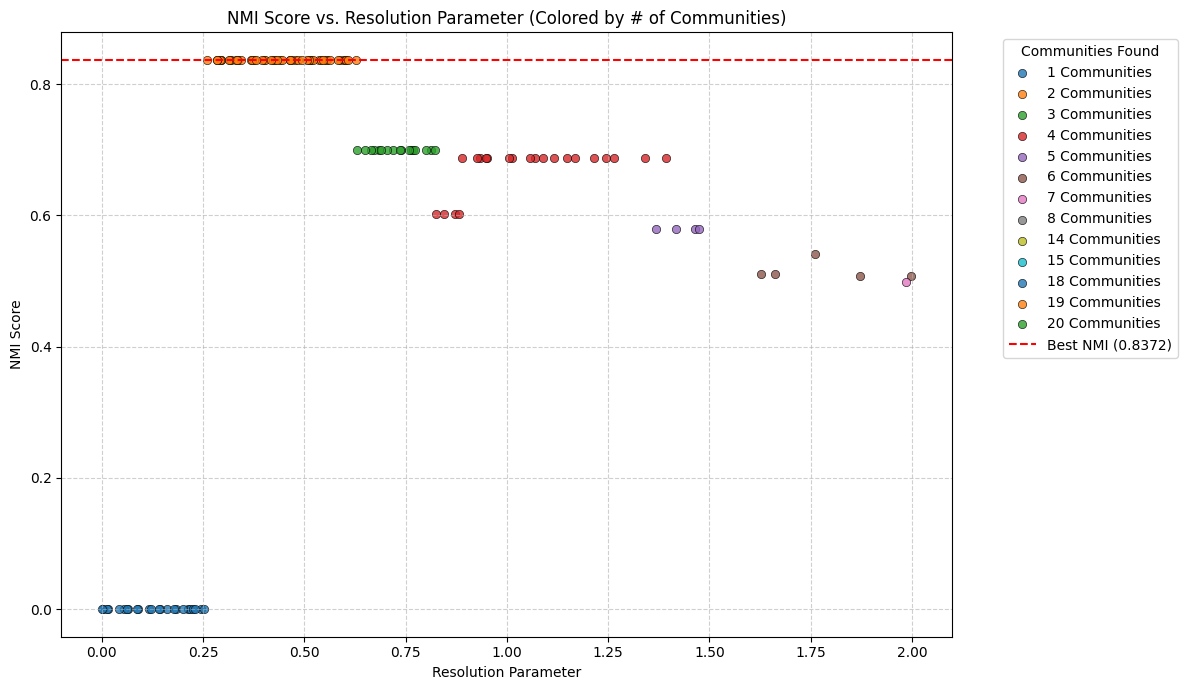

In [30]:
# Create a dictionary to map the number of communities to a specific, distinct color
unique_n_communities = sorted(results_df['num_communities'].unique())
colors = plt.get_cmap('tab10').colors
color_map = {n: colors[i % len(colors)] for i, n in enumerate(unique_n_communities)}

# --- Improved Scatter Plot ---
fig, ax = plt.subplots(figsize=(12, 7))

# Plot each group of points (grouped by number of communities) separately
for n_communities, group_df in results_df.groupby('num_communities'):
    ax.scatter(
        group_df['resolution_parameter'],
        group_df['nmi'],
        color=color_map[n_communities],
        label=f'{n_communities} Communities',
        alpha=0.8,
        edgecolor='k',
        linewidth=0.5
    )

# Add labels, title, and a grid for clarity
ax.set_xlabel('Resolution Parameter')
ax.set_ylabel('NMI Score')
ax.set_title('NMI Score vs. Resolution Parameter (Colored by # of Communities)')
ax.grid(True, linestyle='--', alpha=0.6)

# Highlight the best NMI score found
best_nmi = results_df['nmi'].max()
ax.axhline(y=best_nmi, color='r', linestyle='--', label=f'Best NMI ({best_nmi:.4f})')

# Use a legend instead of a colorbar
ax.legend(title='Communities Found', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()

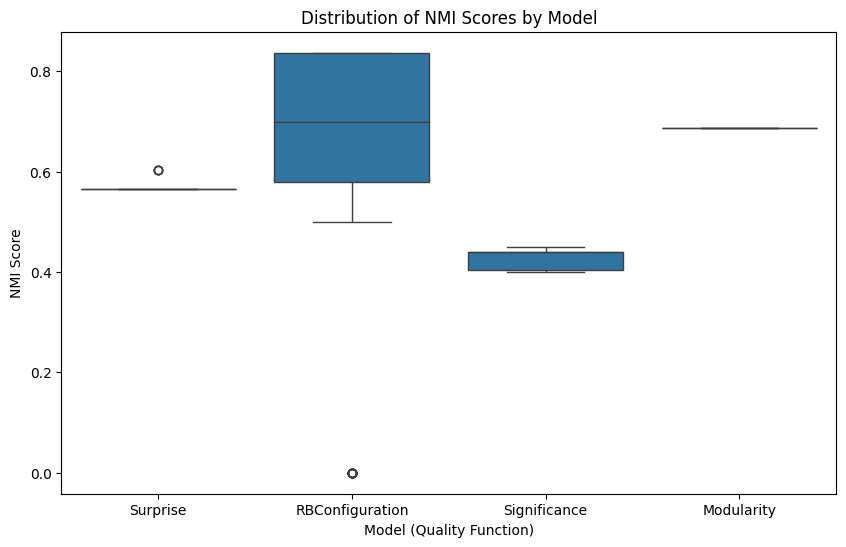

In [31]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

# Create a box plot showing the distribution of NMI scores for each model
sns.boxplot(
    data=results_df,
    x='model_name',
    y='nmi',
    ax=ax
)

ax.set_title('Distribution of NMI Scores by Model')
ax.set_xlabel('Model (Quality Function)')
ax.set_ylabel('NMI Score')

plt.show()

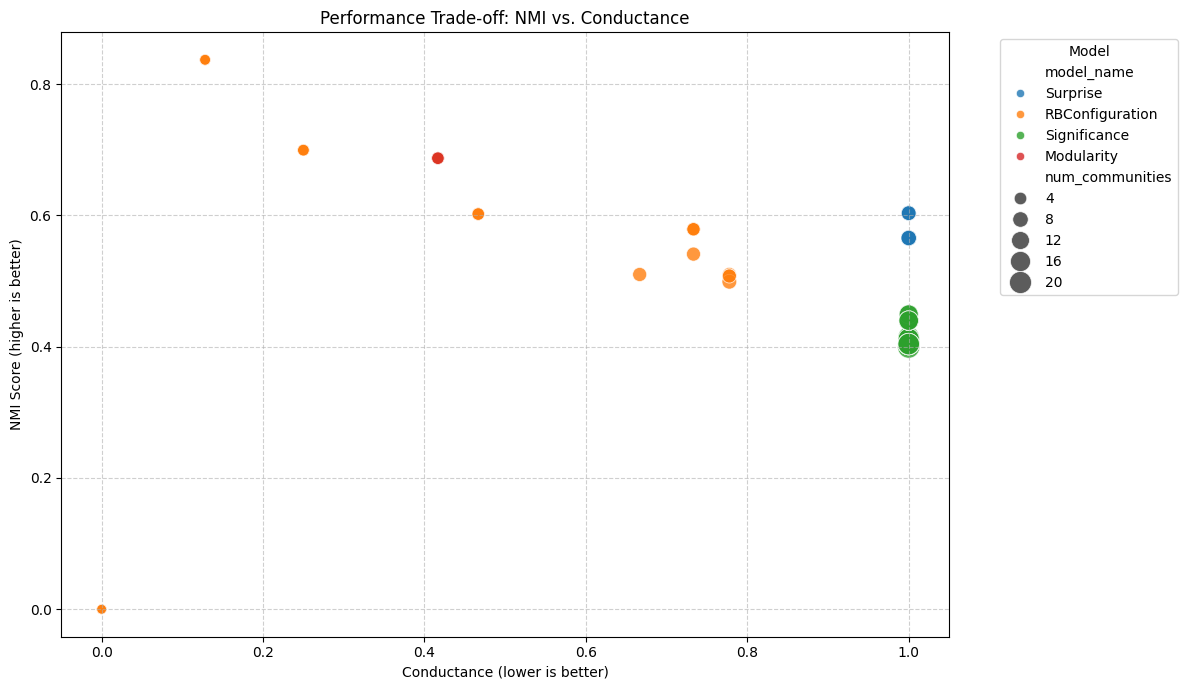

In [32]:
fig, ax = plt.subplots(figsize=(12, 7))

# Create a scatter plot of Conductance vs. NMI
# We color the points by the model name to see if certain models dominate
sns.scatterplot(
    data=results_df,
    x='conductance',
    y='nmi',
    hue='model_name',
    size='num_communities',
    sizes=(50, 250),
    alpha=0.8,
    ax=ax
)

ax.set_title('Performance Trade-off: NMI vs. Conductance')
ax.set_xlabel('Conductance (lower is better)')
ax.set_ylabel('NMI Score (higher is better)')
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()
plt.show()